## Simulation of collimated extended sources for dual-MLA illuminator

In [1]:
%pylab
%matplotlib inline
import SimMLA.fftpack as simfft
import SimMLA.grids   as grids
import SimMLA.fields  as fields

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


This is a test to see whether the code can reproduce Fig. 7c of [Büttner and Zeitner, "Wave optical analysis of light-emitting diode beam shaping using microlens arrays", SPIE, 2002](http://opticalengineering.spiedigitallibrary.org/article.aspx?articleid=1099186).

In [2]:
numLenslets = 11    # Must be odd; corresponds to the number of lenslets in one dimension
lensletSize = 200   # microns
focalLength = lensletSize / 2 / 0.11 # microns

wavelength  = 0.520 # microns

subgridSize  = 1001                     # Number of grid (or lattice) sites for a single lenslet
physicalSize = numLenslets * lensletSize # The full extent of the MLA

# dim = 1 makes the grid 1D
grid = grids.GridArray(numLenslets, subgridSize, physicalSize, wavelength, focalLength, dim = 1, zeroPad = 3)

Propagate the field through the MLA and find the average irradiance.

In [9]:
Z0       = 376.73 # Impedance of free space, Ohms
power    = 100  # mW
beamStd  = 1000 # microns

# Collimating lens
fc = 50000 # microns

# Diffuser properties
# We won't actually create the deterministic Gaussian beam; 
# We generate only random plane waves by setting powerScat = 1
# The ratio of beamSize to grainSize determines the number of independent sources.
grainSize = 100 # microns
beamSize  = 0.68 * lensletSize * fc / focalLength # microns (derived from rho in Büttner and Zeitner, 2002)
powerScat = 1  # fraction of power scattered by diffuser (remove the Gaussian part of the beam)

fieldAmp = np.sqrt(power / 1000 * Z0 / beamStd / np.sqrt(np.pi)) # Factor of 1000 converts from mW to W
beam     = fields.GaussianWithDiffuser(fieldAmp,
                                       beamStd,
                                       physicalSize, # MLA aperture size, not grid size
                                       powerScat  = powerScat,
                                       wavelength = wavelength,
                                       fc         = fc,
                                       grainSize  = grainSize,
                                       beamSize   = beamSize)

fObj         = 100000   # microns

# Grid for interpolating the field after the second MLA
newGridSize = subgridSize * numLenslets # meters
newGrid     = grids.Grid(5*newGridSize, 5*physicalSize, wavelength, fObj, dim = 1)

In [10]:
beamSize

7480.0

In [12]:
beamSize * focalLength / fc / lensletSize + 1 # Should be rho = 1.68

1.6800000000000002

In [18]:
%%time
nIter = 100

avgIrrad = np.zeros(newGrid.px.size, dtype=np.float128)
for realization in range(nIter):

    # Field propagation
    # Compute the interpolated fields
    interpMag, interpPhase = simfft.fftSubgrid(beam, grid)

    field   = np.zeros(newGrid.gridSize)

    # For each interpolated magnitude and phase corresponding to a lenslet
    # 1) Compute the full complex field
    # 2) Sum it with the other complex fields
    for currMag, currPhase in zip(interpMag, interpPhase):
        fieldMag   = currMag(newGrid.px)
        fieldPhase = currPhase(newGrid.px)

        currField = fieldMag * np.exp(1j * fieldPhase)
        field     = field + currField
        
    # No propagation or clipping
    
    # Propagate the field in the BFP to the sample
    scalingFactor = newGrid.physicalSize / (newGrid.gridSize - 1) / np.sqrt(newGrid.wavelength * newGrid.focalLength)
    F             = scalingFactor * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(field)))    
        
    # Compute the irradiance on the sample
    Irrad = np.abs(F)**2 / Z0 * 1000
    
    # Save the results for this realization
    avgIrrad = avgIrrad + Irrad
    
# Average irradiance
avgIrrad = avgIrrad / nIter

CPU times: user 13min 17s, sys: 424 ms, total: 13min 17s
Wall time: 13min 16s


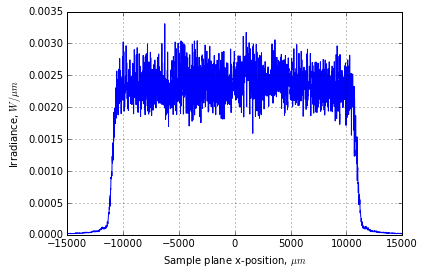

In [21]:
plt.plot(newGrid.pX, avgIrrad)
plt.xlim((-15000,15000))
plt.xlabel(r'Sample plane x-position, $\mu m$')
plt.ylabel(r'Irradiance, $W / \mu m$')
plt.grid(True)
plt.show()

Here is an image of Fig. 7c from Büttner and Zeitner for comparison:

![Flat-top profile for extended source](Fig7c-Büttner.png)